# Forecasting Hourly Taxi Orders with an RMSE Constraint

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.

Train-Test ratio = 4:1

The data is stored in file `taxi.csv`. num_orders for every 10 minutes.

<b> Table of contents </b>

<b> Part 1: Libraries </b>

<b> Part 2: EDA </b>
- data was stored as data_original and data
- data was explored; trends were noted
- 'num_orders' column values overwritten with sum of taxi orders by hour

<b> Part 3: Functions </b>
- RMSE function
- SMAPE function 
- forecast function: takes actual and predictions as input, and returns the RSME, SMAPE and forecast bias, and  returns as plot of the actual and predictions on the same graph for visual comparison. Also adds to the all_model_scores array. 

<b> Part 4: Time Series Feature Engineering </b>
- create_features function
- feature created: lags (1-4) and rolling mean from 4th hour

<b> Part 5: Forecasting With Features </b>
- models: Linear Regressor, Random Forest Regressor, and LightBGM Regressor

<b> Part 6: Forcasting Without Features </b>
- models: AR, and SARIMA

<b> Final Report </b>

## Libraries

In [1]:
import pandas as pd
import numpy as np

# for ploting
from matplotlib import pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

# model
from sklearn.preprocessing import MaxAbsScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import RandomizedSearchCV


# metircs
from sklearn.metrics import mean_squared_error


## EDA

In [2]:
# load data. save original and make a copy
data_original = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
data = data_original.copy()

In [3]:
# data overview
data.head(5)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [5]:
# checking if TS index is sorted 
data.index.is_monotonic

True

<b> First look Notes </b>
* no missing values
* data index seems to be every 10 minutes
* Data is between the months of March and end of August 2018 (2018-03-01 00:00:00 to 2018-08-31 23:50:00)

### Data Cleaning

In [6]:
# saving number of taxi order by hour in 'num_orders' column 
data['num_orders'] = data.resample('1H').sum()
data.dropna(inplace=True)
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124.0
2018-03-01 01:00:00,85.0
2018-03-01 02:00:00,71.0
2018-03-01 03:00:00,66.0
2018-03-01 04:00:00,43.0


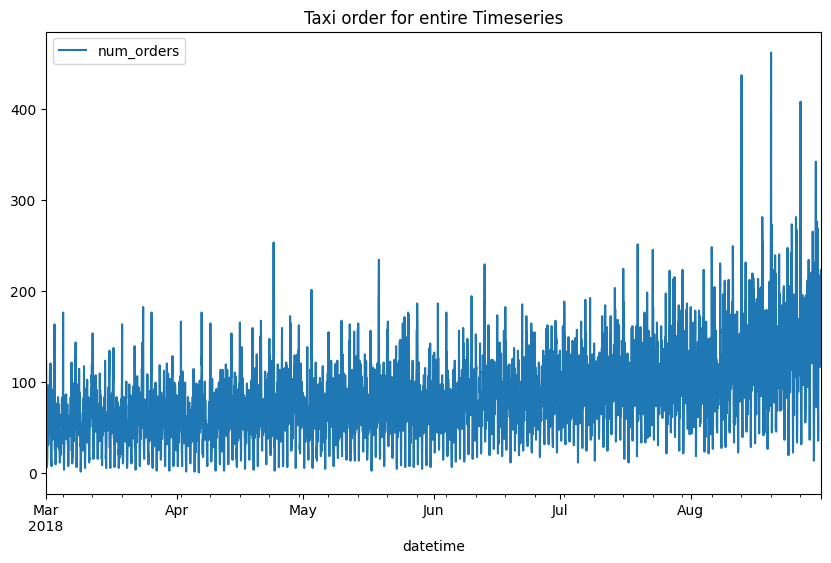

In [7]:
# ploting entire dataset 
data.plot(figsize=(10,6))
plt.title('Taxi order for entire Timeseries')
plt.show()

There seems to be a higher number of taxi orders in August 

### Seasonality 

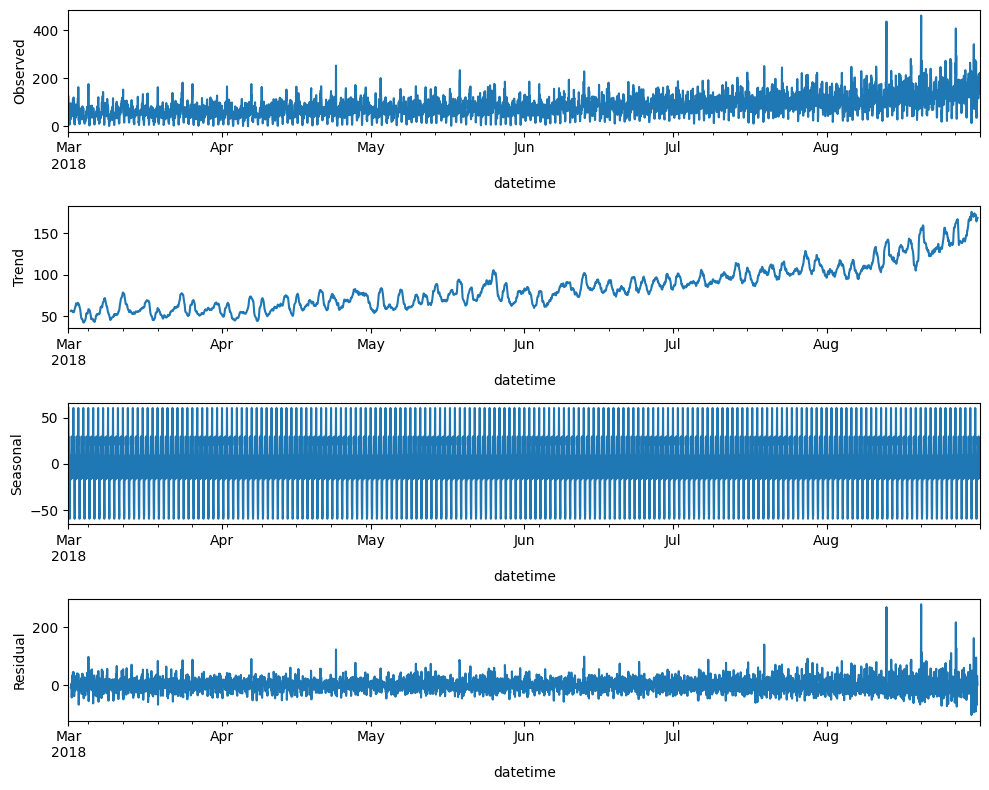

In [8]:
# seasonal decomposition
decomposition = seasonal_decompose(data)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 8))
decomposition.observed.plot(ax=ax1)
ax1.set_ylabel('Observed')
decomposition.trend.plot(ax=ax2)
ax2.set_ylabel('Trend')
decomposition.seasonal.plot(ax=ax3)
ax3.set_ylabel('Seasonal')
decomposition.resid.plot(ax=ax4)
ax4.set_ylabel('Residual')
plt.tight_layout()
plt.show()

* A slow rise in the number of orders every month from march to end of August.  
* there seems to be a daily seasonal trend. 
* the irregular fluctuations are consistent for most of the months but increases greatly in August. 

Text(0.5, 1.0, 'Hourly Seasonality for April 12')

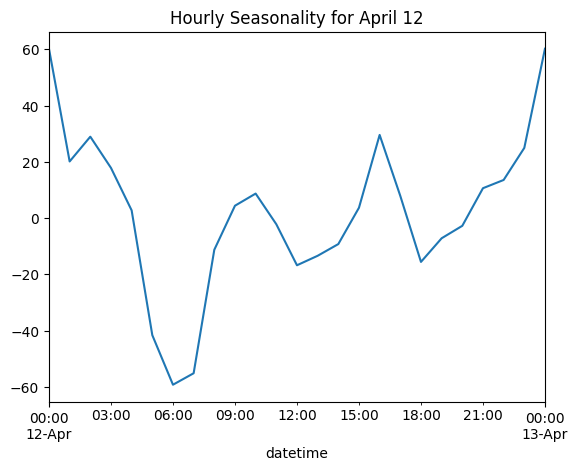

In [9]:
# seasonality for April 12 (random date) to explore hourly seasonality 
decomposition.seasonal['2018-04-12': '2018-04-13 00:00:00'].plot(ax=plt.gca())
plt.title('Hourly Seasonality for April 12')

* High seasonality around midnight. 
* lowest seasonality at 6AM. 
* steep rise at 11AM. a short drop (around 10-12PM) and then another peak around 3 PM. 
* Another drop to less then 0 (6PM) and the a gradual rise to the highest peak till midnight. 

Text(0.5, 1.0, 'scatterplot of Taxi Orders by Hour for 6 months')

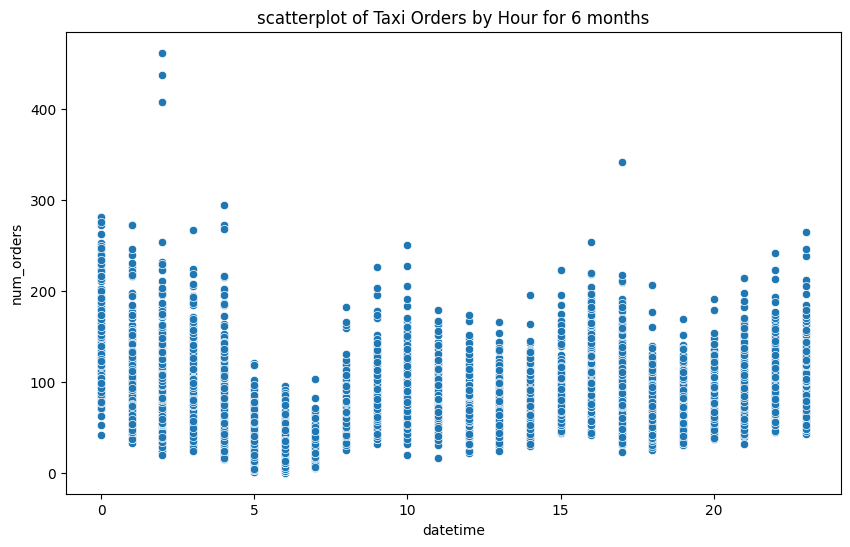

In [10]:
# number of orders by hour for all 6 months
plt.figure(figsize=(10, 6))
sns.scatterplot(x=data.index.hour, y=data['num_orders'])
plt.title('scatterplot of Taxi Orders by Hour for 6 months')

The taxi orders by hour and the hourly seasonlity look to be consistent. Overall the lowest quantity of taxi orders for the 6 months were between 5-7 AM. Highest taxi orders were around midnight. And there were looks to be two peaks between the drop and midnight. 

## Model Evaluation Functions

The goal is to build a model that will forecast hourly taxi orders at an airport, with a <b>RMSE</b> < 48 . The RMSE will highlight the accuracy of the predictions. 

Two more metrics, SMAPE and forecast bias, can help with determining the best model for forecasting orders. 

<b>SMAPE</b> would give the percentage of error (accuracy), taking into consideration both overestimation and underestimation

<b>forecast bias</b> gives an idea of the direction (overestimation and underestimation) and consistency of errors in the predictions. 


In [11]:
# function to calculate RMSE 
def RMSE(actual, predicted):
    return np.sqrt(mean_squared_error(actual, predicted))

In [12]:
# function to calculate RMSE 
def calculate_smape(actual, predicted):
    denominator = (np.abs(actual) + np.abs(predicted)) / 2
    diff = np.abs(actual - predicted) / denominator
    return np.mean(diff) * 100

In [13]:
# function to evaluate model performance and plot time actual and predicted 

# array to store model score
all_model_scores = pd.DataFrame(columns=['RMSE', 'SMAPE', 'Forecast bias'])

def forecast(model_name, actual, predictions):

    # model performance metrics
    mse = mean_squared_error(actual, predictions)
    rmse = np.sqrt(mse)
    
    smape = calculate_smape(actual.values, predictions)

    forecast_bias = np.mean(predictions - actual.values)
    
    # add scores to all_model_scores
    all_model_scores.loc[model_name]= [rmse, smape, forecast_bias]

    print(all_model_scores.loc[model_name])
    
    # print(f"Root Mean Squared Error: {rmse:.2f}")
    # print(f"Symmetric Mean Absolute Percentage Error: {smape:.2f}")
    # print(f"Forecast Bias: {forecast_bias:.2f}")

    # Plot the actual data and predictions
    plt.figure(figsize=(14, 7))
    plt.plot(actual.index, actual, label='Actual')
    plt.plot(actual.index, predictions, label=f'{model_name} Predictions')
    plt.title(f'Taxi Order Forecasting with {model_name}')
    plt.xlabel('Date')
    plt.ylabel('Number of Orders')
    plt.legend()
    plt.show()

In [14]:
random_state = 42 

## Time Series Feature Engineering

In [15]:
data.sample()

,num_orders
datetime,
2018-03-20 05:00:00,5.0


In [16]:
#function to create TS features
def create_features(data, max_lag, rolling_mean):
    timeseries = data.copy()
    # features: 'hour', 'day_of_week', 'month'
    timeseries['hour'] = timeseries.index.hour
    timeseries['day_of_week'] = timeseries.index.dayofweek
    timeseries['month'] = timeseries.index.month
    
    # lags 
    for lag in range(1, max_lag + 1):
        timeseries['lag{}'.format(lag)] = timeseries['num_orders'].shift(lag)
    
    timeseries['rolling_mean'] = timeseries['num_orders'].shift().rolling(rolling_mean).mean()
    
    return timeseries
    

In [17]:
# since there is a daily pattern using 24 lags 
data_with_features = create_features(data, 24, 1)
data_with_features

,num_orders,hour,day_of_week,month,lag1,lag2,lag3,lag4,lag5,lag6,...,lag16,lag17,lag18,lag19,lag20,lag21,lag22,lag23,lag24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124.0,0,3,3,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85.0,1,3,3,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,124.0
2018-03-01 02:00:00,71.0,2,3,3,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,85.0
2018-03-01 03:00:00,66.0,3,3,3,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.0
2018-03-01 04:00:00,43.0,4,3,3,66.0,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,66.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136.0,19,4,8,207.0,217.0,197.0,116.0,133.0,166.0,...,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,72.0,207.0
2018-08-31 20:00:00,154.0,20,4,8,136.0,207.0,217.0,197.0,116.0,133.0,...,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,136.0
2018-08-31 21:00:00,159.0,21,4,8,154.0,136.0,207.0,217.0,197.0,116.0,...,78.0,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,154.0


In [18]:
# dropping null value rows
data_with_features.dropna(inplace=True)

Over the course of the 6 months, 5-7 PM had the least number of orders. Larger quantity of taxi orders was between 0-4 AM. 

## Forecasting with Features

#### Preparing train and test data

In [19]:
# split train and test 
train, test = train_test_split(data_with_features, shuffle=False, test_size=0.2, random_state=random_state)

# train and test data
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_valid= test.drop(['num_orders'], axis=1)
target_valid = test['num_orders']

In [20]:
data_with_features.columns.tolist()

['num_orders',
 'hour',
 'day_of_week',
 'month',
 'lag1',
 'lag2',
 'lag3',
 'lag4',
 'lag5',
 'lag6',
 'lag7',
 'lag8',
 'lag9',
 'lag10',
 'lag11',
 'lag12',
 'lag13',
 'lag14',
 'lag15',
 'lag16',
 'lag17',
 'lag18',
 'lag19',
 'lag20',
 'lag21',
 'lag22',
 'lag23',
 'lag24',
 'rolling_mean']

In [21]:
# list of features that need to be scaled  
columns_to_scale = ['lag1',
 'lag2',
 'lag3',
 'lag4',
 'lag5',
 'lag6',
 'lag7',
 'lag8',
 'lag9',
 'lag10',
 'lag11',
 'lag12',
 'lag13',
 'lag14',
 'lag15',
 'lag16',
 'lag17',
 'lag18',
 'lag19',
 'lag20',
 'lag21',
 'lag22',
 'lag23',
 'lag24',
 'rolling_mean']

In [22]:
# scaling selected features 
max_abs_scaler = MaxAbsScaler().fit(features_train[columns_to_scale].to_numpy())

features_train[columns_to_scale] = max_abs_scaler.transform(features_train[columns_to_scale].to_numpy())
features_valid[columns_to_scale] = max_abs_scaler.transform(features_valid[columns_to_scale].to_numpy())
features_train.head()

,hour,day_of_week,month,lag1,lag2,lag3,lag4,lag5,lag6,lag7,...,lag16,lag17,lag18,lag19,lag20,lag21,lag22,lag23,lag24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-02 00:00:00,0,4,3,0.229249,0.446640,0.260870,0.241107,0.177866,0.288538,0.173913,...,0.134387,0.059289,0.047431,0.023715,0.169960,0.260870,0.280632,0.335968,0.490119,0.229249
2018-03-02 01:00:00,1,4,3,0.355731,0.229249,0.446640,0.260870,0.241107,0.177866,0.288538,...,0.272727,0.134387,0.059289,0.047431,0.023715,0.169960,0.260870,0.280632,0.335968,0.355731
2018-03-02 02:00:00,2,4,3,0.474308,0.355731,0.229249,0.446640,0.260870,0.241107,0.177866,...,0.252964,0.272727,0.134387,0.059289,0.047431,0.023715,0.169960,0.260870,0.280632,0.474308
2018-03-02 03:00:00,3,4,3,0.296443,0.474308,0.355731,0.229249,0.446640,0.260870,0.241107,...,0.379447,0.252964,0.272727,0.134387,0.059289,0.047431,0.023715,0.169960,0.260870,0.296443
2018-03-02 04:00:00,4,4,3,0.252964,0.296443,0.474308,0.355731,0.229249,0.446640,0.260870,...,0.118577,0.379447,0.252964,0.272727,0.134387,0.059289,0.047431,0.023715,0.169960,0.252964


### Linear regression model

RMSE             40.705834
SMAPE            25.069320
Forecast bias    -6.493960
Name: Linear Regression, dtype: float64


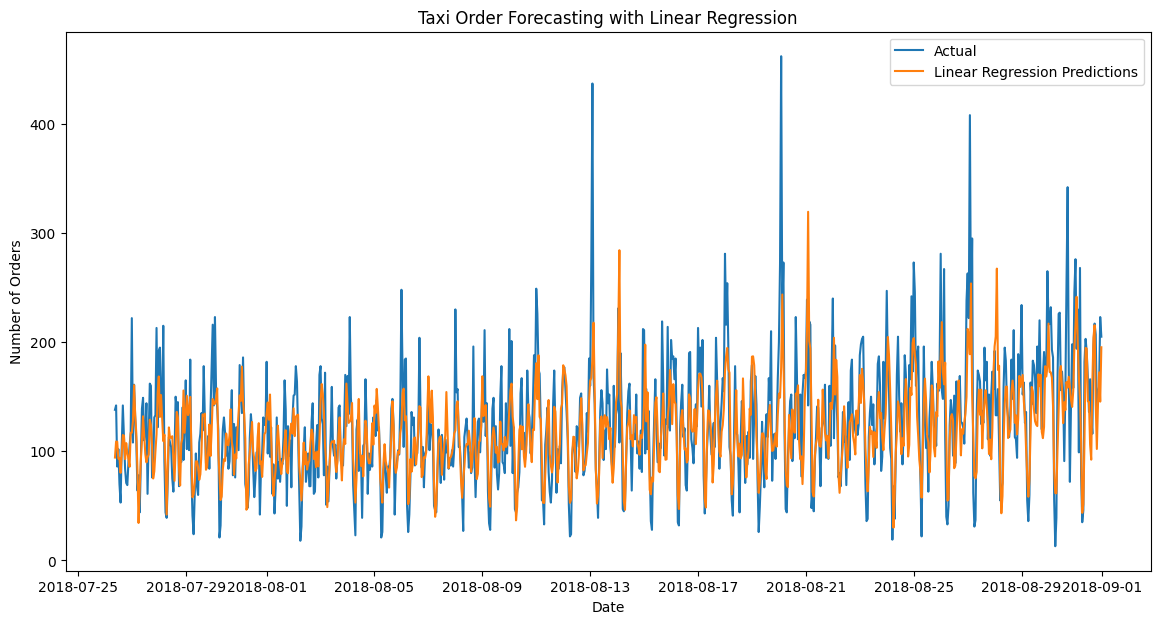

In [23]:
lr_model = LinearRegression()
lr_model.fit(features_train, target_train)
predictions = lr_model.predict(features_valid)
forecast('Linear Regression', target_valid, predictions)

### Random Forest Regression

Best Parameters: {'n_estimators': 40, 'max_depth': 12}
RMSE             42.882068
SMAPE            25.347332
Forecast bias   -16.026312
Name: Random Forest Regression, dtype: float64


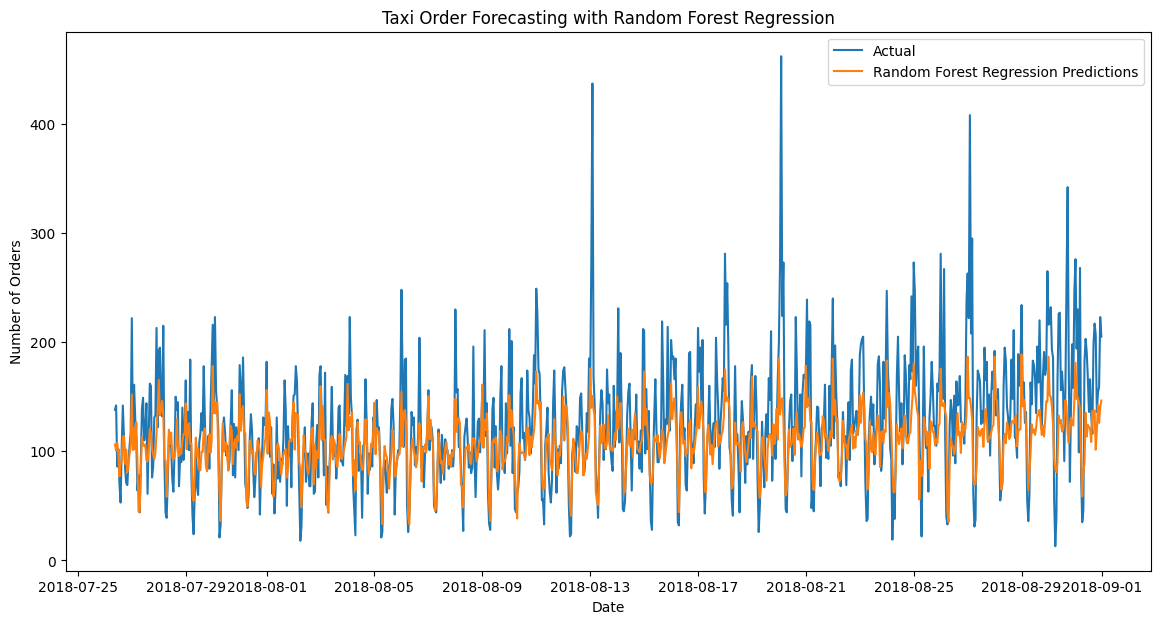

In [24]:
# Define the parameter grid
param_grid = {
    'n_estimators': range(10, 51, 10),
    'max_depth': range(1, 16),
}

# Initialize RandomForestRegressor
model = RandomForestRegressor(random_state=random_state)

# Set up RandomizedSearchCV
# neg_mean_squared_error: optimizing for a low RMSE
random_search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=10, scoring='neg_mean_squared_error', cv=5, random_state=12345)

# Fit the model using RandomizedSearchCV
random_search.fit(features_train, target_train)

# Get the best model
best_model = random_search.best_estimator_

# Make predictions
predictions = best_model.predict(features_valid)

# Output the results
print(f'Best Parameters: {random_search.best_params_}')

forecast('Random Forest Regression', target_valid, predictions)



### LightBGM

Best Parameters: {'n_estimators': 40, 'max_depth': 7, 'learning_rate': 0.1}
RMSE             42.958153
SMAPE            24.897265
Forecast bias   -18.038260
Name: LGBM Regression, dtype: float64


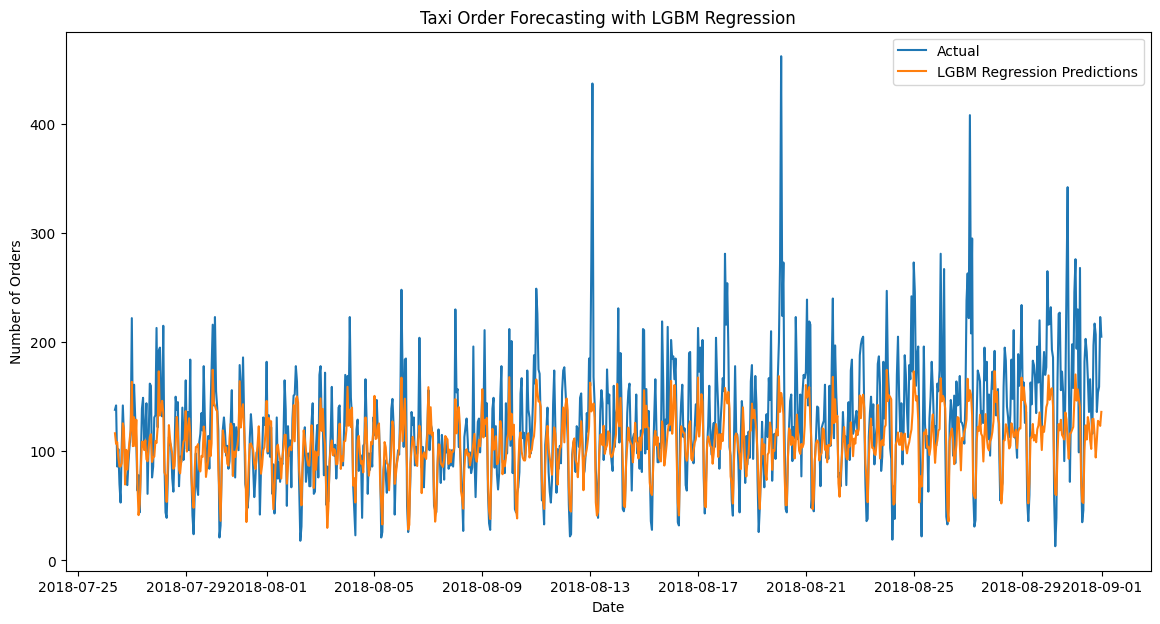

In [25]:
# Define the parameter grid
param_grid = {
    'n_estimators': range(10, 51, 10),
    'max_depth': range(1, 16),
    'learning_rate': [0.001, 0.01, 0.1, 0.2]
}

# Initialize LGBMRegressor
model = LGBMRegressor(random_state=random_state)

# Set up RandomizedSearchCV
# optimizing for a low RMSE
random_search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=10, scoring='neg_mean_squared_error', cv=5, random_state=12345)

# Fit the model using RandomizedSearchCV
random_search.fit(features_train, target_train)

# Get the best model
best_model = random_search.best_estimator_

# Make predictions
predictions = best_model.predict(features_valid)

print(f'Best Parameters: {random_search.best_params_}')

forecast('LGBM Regression', target_valid, predictions)


In [26]:
# model scores on features test set
all_model_scores

,RMSE,SMAPE,Forecast bias
Linear Regression,40.705834,25.069320,-6.493960
Random Forest Regression,42.882068,25.347332,-16.026312
LGBM Regression,42.958153,24.897265,-18.038260


<b> Model training with features: </b>
Of the models in this section, the Random Forest Regressor and LBGMRegressor models returned had a RMSE less than 48. The SMAPE was also lowers for both but the Forecast bias reveals a higher underestimation that is also noticable on the plots. 

## Forcasting Without Features 

### Spliting data into train and test sets

In [27]:
# frequency of datetime series
frequency = pd.infer_freq(data.index)

In [28]:
# test set 20% of the data for models that do not require features 
train, test = train_test_split(data.asfreq(frequency), shuffle=False, test_size=0.2)

### Is the data sationary?

In [29]:
from statsmodels.tsa.stattools import adfuller
df_stationarityTest = adfuller(train, autolag='AIC')
print("P-value: ", df_stationarityTest[1])

P-value:  4.399530277075988e-05


* The p-value, 0.000043995 < 0.05 therefore, the data is likely stationary. 
* The AR could be trained

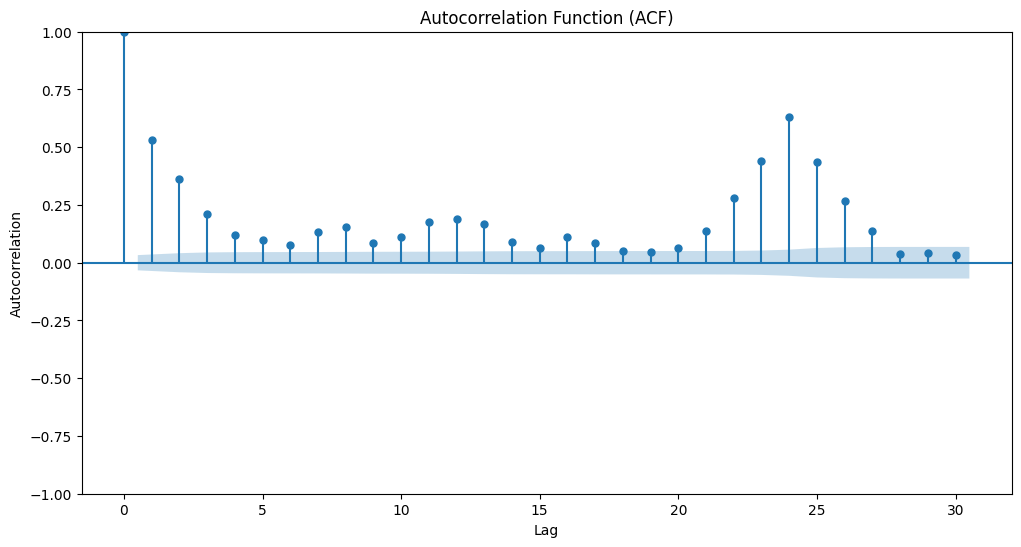

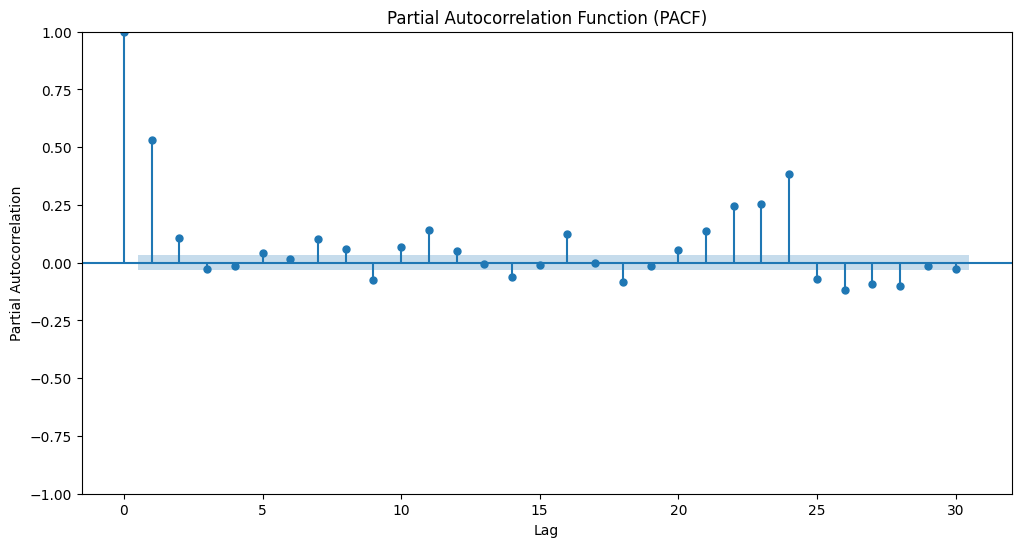

In [30]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot autocorrelation function (ACF)
plt.figure(figsize=(12, 6))
plot_acf(train, lags=30, ax=plt.gca(), alpha=0.05)
plt.title('Autocorrelation Function (ACF)')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

# Plot partial autocorrelation function (PACF)
plt.figure(figsize=(12, 6))
plot_pacf(train, lags=30, ax=plt.gca(), alpha=0.05)
plt.title('Partial Autocorrelation Function (PACF)')
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.show()


* Both the ACF and PACF plots show a peak at lag 24. there is clearly a daily seasonality. SARIMA could be a potential model for forecasting 
* The AR model order can be taken from the PACF peaks. [1, 2, 5, 7, 8, 11, 12, 16, 22, 23, 24] 


In [31]:
# for forcasting test set
start_index = len(train)
end_index = len(train) + len(test) - 1

### AutoRegressive Model

In [32]:
from statsmodels.tsa.ar_model import AutoReg


RMSE             54.974455
SMAPE            35.196935
Forecast bias   -12.453870
Name: AutoRegressive Model, dtype: float64


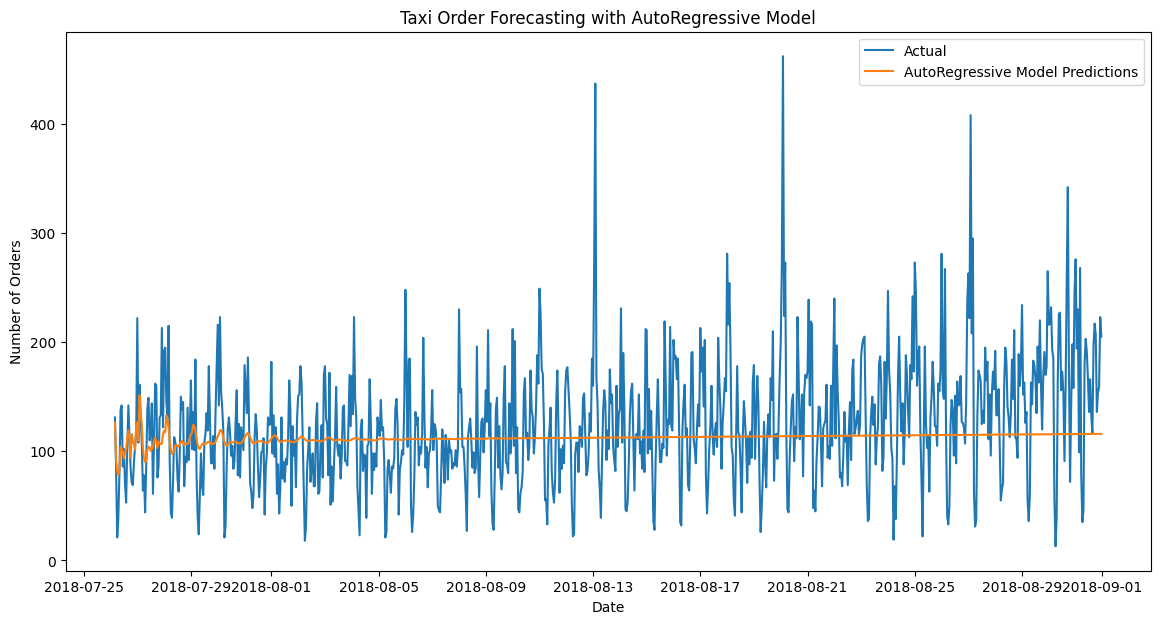

In [33]:
# Non-Seasonal AR Model
order = [1, 2, 5, 7, 8, 11, 12, 16, 22, 23, 24]  # Order of the AR model 
ar_model = AutoReg(train.values, lags=order)
ar_model_fit = ar_model.fit()

ar_forecast = ar_model_fit.predict(start=start_index, end=end_index)
forecast('AutoRegressive Model', test, ar_forecast)

### SARIMA model (24 lags seasonality)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.59647D+00    |proj g|=  7.50139D-02


 This problem is unconstrained.



At iterate    5    f=  4.50622D+00    |proj g|=  1.50278D-02

At iterate   10    f=  4.43654D+00    |proj g|=  8.87752D-03

At iterate   15    f=  4.43557D+00    |proj g|=  9.87317D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     19      1     0     0   9.873D-06   4.436D+00
  F =   4.4355674676312944     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RMSE             37.949049
SMAPE            39.550601
Forecast bias    -0.736403
Name: SARIMA Model, dtype: float64


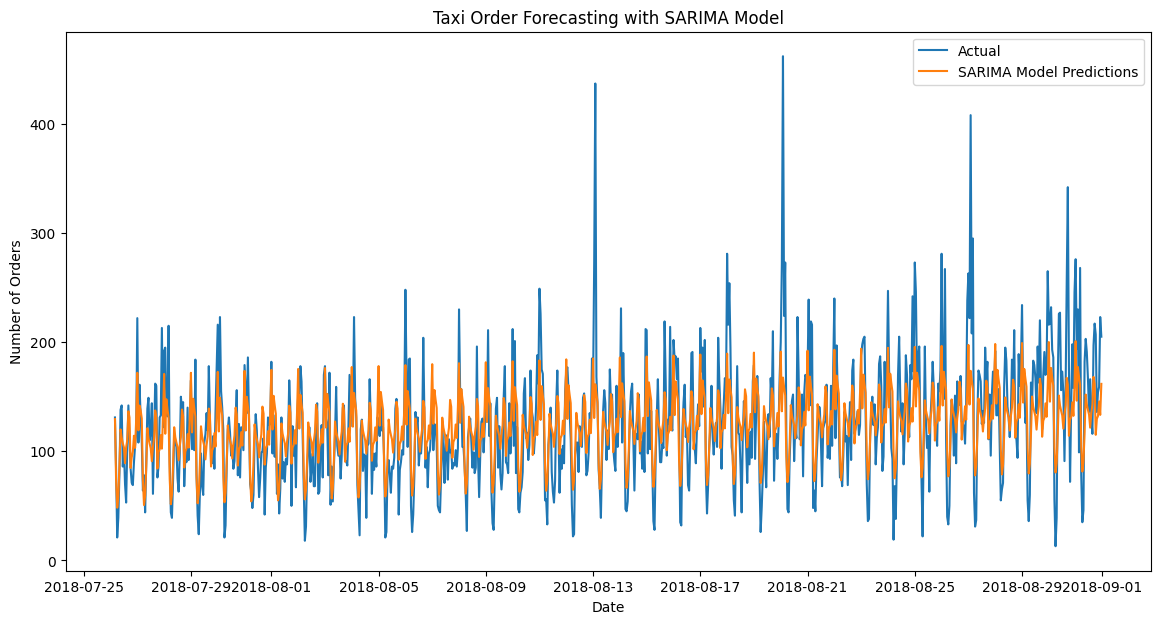

In [34]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# non-seasonal order (p, d, q)
order = (0, 1, 1)  # p set to 0 because the previous hour orders doesn't have a direct impact on the orders for next hour 
# seasonal order (P, D, Q, S) S=24, ACF and PACF peaks around 24 lags 
seasonal_order = (1, 1, 1, 24)  
sarima_model = SARIMAX(train, order=order, seasonal_order=seasonal_order)

# Fit SARIMAX model
sarima_model_fit = sarima_model.fit()
sarima_forecast = sarima_model_fit.predict(start=start_index, end=end_index)
forecast('SARIMA Model', test, sarima_forecast.values)

In [35]:
# AR and SARIMA model scores
all_model_scores[-2:]

,RMSE,SMAPE,Forecast bias
AutoRegressive Model,54.974455,35.196935,-12.453870
SARIMA Model,37.949049,39.550601,-0.736403


The AutoRegressive Model failed to have a RMSE below 48. The SARIMA model has a RMSE below 48 and the lowest compared to the previous model's RMSE.

## Model Performance Scores

In [36]:
df_transposed = all_model_scores.transpose()
df_transposed

,Linear Regression,Random Forest Regression,LGBM Regression,AutoRegressive Model,SARIMA Model
RMSE,40.705834,42.882068,42.958153,54.974455,37.949049
SMAPE,25.069320,25.347332,24.897265,35.196935,39.550601
Forecast bias,-6.493960,-16.026312,-18.038260,-12.453870,-0.736403


<Figure size 1000x600 with 0 Axes>

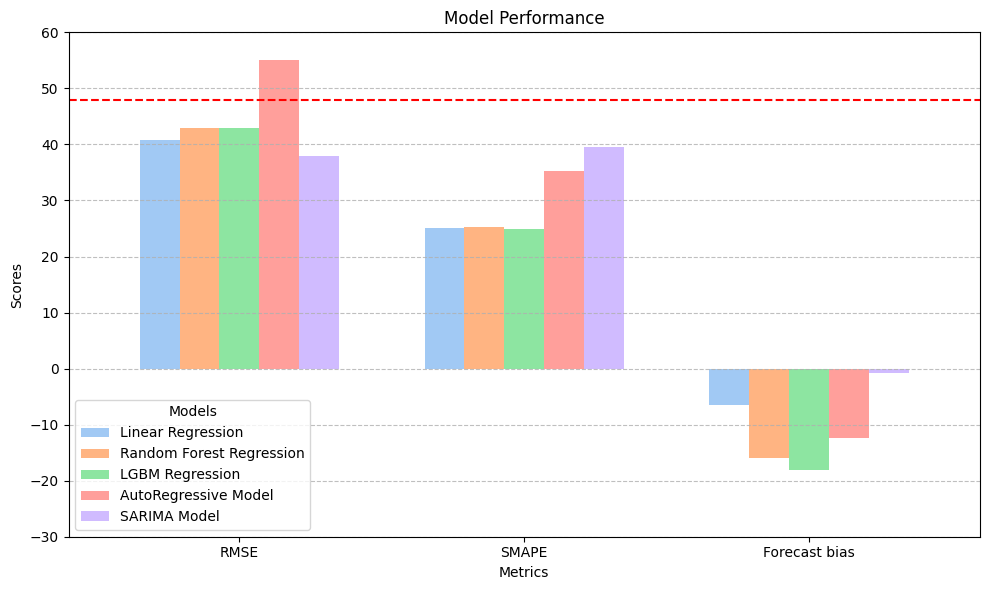

In [37]:
# Transpose the DataFrame for plotting
df_transposed = all_model_scores.transpose()

pastel_palette = sns.color_palette('pastel', n_colors=len(df_transposed.columns))

# Plotting
plt.figure(figsize=(10, 6))
df_transposed.plot(kind='bar', width=0.7, figsize=(10,6), color=pastel_palette)
plt.title('Model Performance')
plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.xticks(rotation=0)
plt.legend(title='Models')
plt.yticks(range(-30, 61, 10))
plt.grid(axis='y', linestyle='--', alpha=0.8)
plt.axhline(y=48, color='red', linestyle='--', label='RMSE threshold Line (48)')

plt.tight_layout()
plt.show()

The goal was to build a forecast model with a RMSE below 48. Four models achived this: SARIMA, Linear Regressor, LightGBM, and the Random Forest Regressor.

Overall Two models performed the best on the test set: SARIMA model  and the Linear Regressor

The hypertuned SARIMA model has the lowest RMSE (37.95) and the lowest Forecast Bias (-0.74). However its SMAPE, 39.6, is higher than the rest of the models. Though the model is accurate on average there is a larger error to the actual. 

The <b>Linear Regression model</b> has a low SMAPE of 25.1 and the second lowest forecast bias and RMSE after the SARIMA model. With these metrics, the LR model demonstrates potential to accurately forecast hourly taxi orders at an airport with minimal absolute errors and a low percentage of error relative to the actual values. 

# Conclusions

The Sweet Lift Taxi company's data: a 6-month time series with number of taxi orders at an airport by every 10 minutes.

The data was cleaned and explored. 

Two processes were taken two build forecasting models: 
* with features (24 lags, rolling mean): Linear regression, Random Forest Regressor, and LGBM Regressor 
* without features: AutoRegressive model and Seasonal ARIMA model 

<b>The Linear Regressor's overall performance seen through the metric scores, show the potential of this model in accurately forecasting with minimal relative and average errors. </b>

In [48]:
# Linear Regression model scores
all_model_scores.loc['Linear Regression']

RMSE             40.705834
SMAPE            25.069320
Forecast bias    -6.493960
Name: Linear Regression, dtype: float64